In [119]:
import sys
sys.path.append('..')
import time
import numpy as np
import matplotlib.pyplot as plt
import pickle

# LSTM 계층 구현

아래는 LSTM 역전파에서 이루어지는 계산을 보여주는 계산 그래프

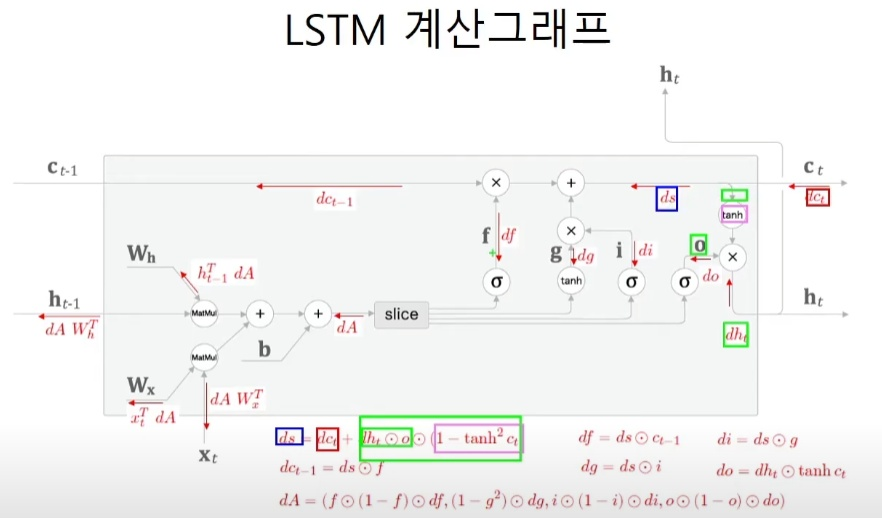

In [120]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def softmax(x):
  if x.ndim == 2:
      x = x - x.max(axis=1, keepdims=True)
      x = np.exp(x)
      x /= x.sum(axis=1, keepdims=True)
  elif x.ndim == 1:
      x = x - np.max(x)
      x = np.exp(x) / np.sum(np.exp(x))

  return x

In [121]:
class LSTM:
  def __init__(self, Wx, Wh, b):
    self.params = [Wx, Wh, b]
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
    self.cache = None

  def forward(self, x, h_prev, c_prev):
    Wx, Wh, b = self.params
    N, H = h_prev.shape

    #print('N : {}, H : {}'.format(N, H))

    A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b

    #print('A.shape : {}'.format(A.shape))

    # slice
    f = A[:, :H]
    g = A[:, H:2*H]
    i = A[:, 2*H:3*H]
    o = A[:, 3*H:]

    f = sigmoid(f) # forget gateway
    g = np.tanh(g) # 새로 기억될 input 정보
    i = sigmoid(i) # input gateway
    o = sigmoid(o) # output gateway

    '''
    cell update 과정
    forget gateway에서 주는 가중치와 이전 c를 아다마르 곱셈하여 중요하지 않은 것은 잊어주고
    input gateway에서 주는 가중치와 새로운 입력 g를 아다마르 곱셈하여 새로운 정보를 추가해준다.
    '''

    #print('f.shape : {}'.format(f.shape))
    #print('c_prev.shape : {}'.format(c_prev.shape))
    #print('g.shape : {}'.format(g.shape))
    #print('i.shape : {}'.format(i.shape))

    c_next = f * c_prev + g * i
    h_next = o * np.tanh(c_next) # output gateway에서 주는 가중치와 아다마르 곱셈으로 출력을 조절

    self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
    return h_next, c_next

  def backward(self, dh_next, dc_next):
    '''
    위의 이미지를 참고하자...
    순전파 때 분기했을 경우 -> 역전파에서는 각 기울기가 합산되어 전해짐
    '''

    Wx, Wh, b = self.params
    x, h_prev, c_prev, i, f, g, o, c_next = self.cache

    ds = dc_next + (dh_next * o) * (1 - np.tanh(c_next)**2) # tanh(c_next) 미분

    dc_prev = ds * f

    di = ds * g
    df = ds * c_prev
    do = dh_next * np.tanh(c_next)
    dg = ds * i

    di *= i * (1-i)
    df *= f * (1-f)
    do *= o * (1-o)
    dg *= (1 - g ** 2)

    dA = np.hstack((df, dg, di, do))

    dWh = np.dot(h_prev.T, dA)
    dWx = np.dot(x.T, dA)
    db = dA.sum(axis=0)

    # 기울기 값 저장
    self.grads[0][...] = dWx
    self.grads[1][...] = dWh
    self.grads[2][...] = db

    dx = np.dot(dA, Wx.T)
    dh_prev = np.dot(dA, Wh.T)

    return dx, dh_prev, dc_prev

In [122]:
class TimeLSTM:
  def __init__(self, Wx, Wh, b, stateful=False):
    self.params = [Wx, Wh, b]
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
    self.layers = None

    self.h, self.dh, self.c = None, None, None
    self.stateful = stateful

  def forward(self, xs):
    Wx, Wh, b = self.params
    N, T, D = xs.shape  # N:미니배치 크기, T:시계열 데이터의 분량, D:입력벡터의 차원 수
    H = Wh.shape[0]     # Wh 형상 : (H, 4H)

    self.layers = []
    hs = np.empty((N, T, H), dtype='f')

    if not self.stateful or self.h is None:
      self.h = np.zeros((N, H), dtype='f')
    if not self.stateful or self.c is None:
      self.c = np.zeros((N, H), dtype='f')

    for t in range(T):
      layer = LSTM(*self.params)
      self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
      hs[:, t, :] = self.h

      self.layers.append(layer)

    return hs

  def backward(self, dhs):
    Wx, Wh, b = self.params
    N, T, H = dhs.shape     # N:미니배치 크기, T:시계열 데이터 분량, H:은닉 벡터의 차원 수
    D = Wx.shape[0]         # D:입력벡터의 차원 수

    dxs = np.empty((N, T, D), dtype='f')  # 역전파 입력
    dh, dc = 0, 0                         # 역전파를 거치며 합산된 기울기
    grads = [0, 0, 0]

    for t in reversed(range(T)): # 역순서로 순회
      layer = self.layers[t]
      dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
      dxs[:, t, :] = dx          # 각 시각 t에서 얻은 x 기울기를 저장

      # t를 순회할 때마다 역전파로 얻은 가중치를 위 로컬변수로 초기화 한 grads에 합산
      for i, grad in enumerate(layer.grads):
        grads[i] += grad

    # 합산된 가중치 기울기의 최종 결과를 멤버변수 self.grads에 덮어씀
    for i, grad in enumerate(grads):
      self.grads[i][...] = grad

    self.dh = dh

    return dxs

  def set_state(self, h, c=None):
    self.h, self.c = h, c

  def reset_state(self):
    self.h, self.c = None, None

#TimeLSTM 계층을 사용하여 언어 모델 구현

언어 모델 구현에 필요한 Time Embedding 층

In [123]:
class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None

    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out

    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        np.add.at(dW, self.idx, dout)
        return None

class TimeEmbedding:
  def __init__(self, W):
    self.params = [W]
    self.grads = [np.zeros_like(W)]
    self.layers = None
    self.W = W

  def forward(self, xs):
    N, T = xs.shape
    V, D = self.W.shape

    out = np.empty((N, T, D), dtype='f')
    self.layers = []

    for t in range(T):
      layer = Embedding(self.W)
      out[:, t, :] = layer.forward(xs[:, t])
      self.layers.append(layer)

    return out

  def backward(self, dout):
    N, T, D = dout.shape

    grad = 0
    for t in range(T):
      layer = self.layers[t]
      layer.backward(dout[:, t, :])
      grad += layer.grads[0]

    self.grads[0][...] = grad
    return None


언어 모델 구현에 필요한 Time Affine 층

In [124]:
class Affine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        W, b = self.params
        out = np.dot(x, W) + b
        self.x = x
        return out

    def backward(self, dout):
        W, b = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        db = np.sum(dout, axis=0)

        self.grads[0][...] = dW
        self.grads[1][...] = db
        return dx

class TimeAffine:
  def __init__(self, W, b):
    self.params = [W, b]
    self.grads = [np.zeros_like(W), np.zeros_like(b)] # 가중치와 편향의 기울기를 저장
    self.x = None

  def forward(self, x):
    N, T, D = x.shape
    W, b = self.params

    rx = x.reshape(N*T, -1)
    out = np.dot(rx, W) + b
    self.x = x
    return out.reshape(N, T, -1)

  def backward(self, dout):
    x = self.x
    N, T, D = x.shape
    W, b = self.params

    dout = dout.reshape(N*T, -1)
    rx = x.reshape(N*T, -1)

    db = np.sum(dout, axis=0)
    dW = np.dot(rx.T, dout)
    dx = np.dot(dout, W.T)
    dx = dx.reshape(*x.shape)

    self.grads[0][...] = dW
    self.grads[1][...] = db

    return dx

Softmax 계층을 구현할 때에는 손실 오차를 구하는 Cross Entropy Error 계층을 함께 구현한다. 여기에서는 모든 산출된 손실을 합산하여 평균한 값을 최종 손실로 산출한다.

In [125]:
class TimeSoftmaxWithLoss:
  def __init__(self):
    self.params, self.grads = [], []
    self.cache = None
    self.ignore_label = -1


  def softmax(self, x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))

    return x

  def forward(self, xs, ts): # xs : 전달받는 점수(확률로 정규화되기 전의 값), ts 정답 레이블
    N, T, V = xs.shape

    if ts.ndim == 3: # 정답 레이블이 원핫 벡터인 경우
      ts = ts.argmax(axis=2)

    mask = (ts != self.ignore_label)

    # 배치용과 시계열용을 정리(reshape)
    xs = xs.reshape(N * T, V)
    ts = ts.reshape(N * T)
    mask = mask.reshape(N * T)

    ys = self.softmax(xs)
    ls = np.log(ys[np.arange(N * T), ts])
    ls *= mask                # ignore_label에 해당하는 데이터는 손실을 0으로 설정
    loss = -np.sum(ls)
    loss /= mask.sum()        # loss 값들을 합산하고 평균을 낸다

    self.cache = (ts, ys, mask, (N, T, V))
    return loss

  def backward(self, dout=1):
    ts, ys, mask, (N, T, V) = self.cache

    dx = ys
    dx[np.arange(N * T), ts] -= 1
    dx *= dout
    dx /= mask.sum()
    dx *= mask[:, np.newaxis]  # ignore_label에 해당하는 데이터는 기울기를 0으로 설정

    dx = dx.reshape((N, T, V))

    return dx

RNN_from_scratch.ipynb의 SimpleRnnlm보다 개선된 Rnnlm 클래스

SimpleRnnlm과 다른 점
- 순수 RNN 계층 대신 LSTM 계층을 사용
- predict, save_params, load_params 메소드 추가

In [126]:
class Rnnlm:
  def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
    V, D, H = vocab_size, wordvec_size, hidden_size
    rn = np.random.randn

    # 가중치 초기화
    embed_W = (rn(V, D) / 100).astype('f')
    lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')    # Xavier 초기값 , 주의할 점은 f,i,g,o 에 대한 파라미터를 합쳐 D, 4H 형상이라는 점
    lstm_Wh = (rn(H,4 * H) / np.sqrt(H)).astype('f')    # Xavier 초기값
    lstm_b = np.zeros(4 * H).astype('f')
    affine_W = (rn(H, V) / np.sqrt(H)).astype('f')  # Xavier 초기값
    affine_b = np.zeros(V).astype('f')

    # 계층 생성
    self.layers = [
        TimeEmbedding(embed_W),
        TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
        TimeAffine(affine_W, affine_b)
    ]
    self.loss_layer = TimeSoftmaxWithLoss()
    self.lstm_layer = self.layers[1]

    # 모든 가중치와 기울기를 리스트에 모은다.
    self.params, self.grads = [], []
    for layer in self.layers:
      self.params += layer.params
      self.grads += layer.grads

  # SimpleRnnlm과 차이는 아래 메서드 추가됐다는 점.. 임베딩, LSTM, 어파인 계층을 통과
  def predict(self, xs):
    for layer in self.layers:
      xs = layer.forward(xs)
    return xs

  def forward(self, xs, ts):
    score = self.predict(xs)
    loss = self.loss_layer.forward(score, ts) # 손실 계층에 전달 (크로스엔트로피)
    return loss # 손실을 반환

  def backward(self, dout=1):
    dout = self.loss_layer.backward(dout)
    for layer in reversed(self.layers):
      dout = layer.backward(dout)
    return dout

  def reset_state(self):
    self.lstm_layer.reset_state()

  # 파라미터를 파일로 저장 (가중치, 편향)
  def save_params(self, file_name='Rnnlm.pk1'):
    with open(file_name, 'wb') as f:
      pickle.dump(self.params, f)

  # 저장된 파일 내 파라미터를 로드
  def load_params(self, file_name='Rnnlm.pk1'):
    with open(file_name, 'rb') as f:
      self.params = pickle.load(f)

# 위의 언어모델을 이용하여 PTB 데이터셋을 학습

In [127]:
# 사용할 옵티마이저는 아래 SGD(Stochastic Gradient Descent)
class SGD:
    '''
    확률적 경사하강법(Stochastic Gradient Descent)
    '''
    def __init__(self, lr=0.01):
        self.lr = lr

    def update(self, params, grads):
        for i in range(len(params)):
            params[i] -= self.lr * grads[i]

아래의 RnnlmTrainer 클래스를 사용하여 모델을 학습시킨다.

fit() 메서드는 모델의 기울기를 구해 모델의 매개변수를 갱신한다.

In [128]:
def clip_grads(grads, max_norm):
    '''
    기울기 클리핑 : 기울기 값이 임계치 이상일 경우, 수식을 적용하여 기울기 폭증을 막는 기법
    '''
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate

def remove_duplicate(params, grads):
    '''
    매개변수 배열 중 중복되는 가중치를 하나로 모아
    그 가중치에 대응하는 기울기를 더한다.
    '''
    params, grads = params[:], grads[:]  # copy list

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                # 가중치 공유 시
                if params[i] is params[j]:
                    grads[i] += grads[j]  # 경사를 더함
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                # 가중치를 전치행렬로 공유하는 경우(weight tying)
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break

        if not find_flg: break

    return params, grads


class RnnlmTrainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.time_idx = None
        self.ppl_list = None
        self.eval_interval = None
        self.current_epoch = 0

    def get_batch(self, x, t, batch_size, time_size):
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')

        data_size = len(x)
        jump = data_size // batch_size
        offsets = [i * jump for i in range(batch_size)]  # 배치에서 각 샘플을 읽기 시작하는 위치

        for time in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, time] = x[(offset + self.time_idx) % data_size]
                batch_t[i, time] = t[(offset + self.time_idx) % data_size]
            self.time_idx += 1
        return batch_x, batch_t

    def fit(self, xs, ts, max_epoch=10, batch_size=20, time_size=35,
            max_grad=None, eval_interval=20):
        data_size = len(xs)
        max_iters = data_size // (batch_size * time_size)
        self.time_idx = 0
        self.ppl_list = []
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            for iters in range(max_iters):
                batch_x, batch_t = self.get_batch(xs, ts, batch_size, time_size)

                # 기울기를 구해 매개변수 갱신
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)  # 공유된 가중치를 하나로 모음
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # 퍼플렉서티 평가
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    ppl = np.exp(total_loss / loss_count)
                    elapsed_time = time.time() - start_time
                    print('| 에폭 %d |  반복 %d / %d | 시간 %d[s] | 퍼플렉서티 %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, ppl))
                    self.ppl_list.append(float(ppl))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = np.arange(len(self.ppl_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.ppl_list, label='train')
        plt.xlabel('반복 (x' + str(self.eval_interval) + ')')
        plt.ylabel('퍼플렉서티')
        plt.show()

하이퍼파라미터 설정

In [129]:
batch_size = 20
wordvec_size = 100
hidden_size= 100    # RNN/LSTM의 은닉 상태 벡터의 원소 수
time_size = 35      # 시계열데이터 분량 (RNN/LSTM을 펼치는 크기)
lr = 20.0
max_epoch = 4
max_grad = 0.25

학습 데이터 읽기

In [130]:
from dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

In [131]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


모델 생성, 옵티마이저, 스케줄러(trainer) 준비

In [132]:
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

기울기 클리핑을 적용하여 학습

기울기 클리핑 : 기울기 값이 임계치 이상일 경우, 수식을 적용하여 기울기 폭증을 막는 기법

| 에폭 1 |  반복 1 / 1327 | 시간 0[s] | 퍼플렉서티 10002.19
| 에폭 1 |  반복 21 / 1327 | 시간 6[s] | 퍼플렉서티 2752.19
| 에폭 1 |  반복 41 / 1327 | 시간 14[s] | 퍼플렉서티 1199.82
| 에폭 1 |  반복 61 / 1327 | 시간 20[s] | 퍼플렉서티 983.90
| 에폭 1 |  반복 81 / 1327 | 시간 28[s] | 퍼플렉서티 788.09
| 에폭 1 |  반복 101 / 1327 | 시간 34[s] | 퍼플렉서티 666.34
| 에폭 1 |  반복 121 / 1327 | 시간 42[s] | 퍼플렉서티 624.36
| 에폭 1 |  반복 141 / 1327 | 시간 48[s] | 퍼플렉서티 597.25
| 에폭 1 |  반복 161 / 1327 | 시간 56[s] | 퍼플렉서티 587.73
| 에폭 1 |  반복 181 / 1327 | 시간 62[s] | 퍼플렉서티 582.97
| 에폭 1 |  반복 201 / 1327 | 시간 71[s] | 퍼플렉서티 504.73
| 에폭 1 |  반복 221 / 1327 | 시간 77[s] | 퍼플렉서티 488.72
| 에폭 1 |  반복 241 / 1327 | 시간 85[s] | 퍼플렉서티 444.14
| 에폭 1 |  반복 261 / 1327 | 시간 91[s] | 퍼플렉서티 458.12
| 에폭 1 |  반복 281 / 1327 | 시간 98[s] | 퍼플렉서티 462.40
| 에폭 1 |  반복 301 / 1327 | 시간 105[s] | 퍼플렉서티 385.88
| 에폭 1 |  반복 321 / 1327 | 시간 113[s] | 퍼플렉서티 339.91
| 에폭 1 |  반복 341 / 1327 | 시간 119[s] | 퍼플렉서티 405.63
| 에폭 1 |  반복 361 / 1327 | 시간 126[s] | 퍼플렉서티 406.59
| 에폭 1 |  반복 381 / 1327 | 시간 134[s] | 퍼플렉서티 331.21

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54140 (\N{HANGUL SYLLABLE PEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54540 (\N{HANGUL SYLLABLE PEUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47113 (\N{HANGUL SYLLABLE REG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages

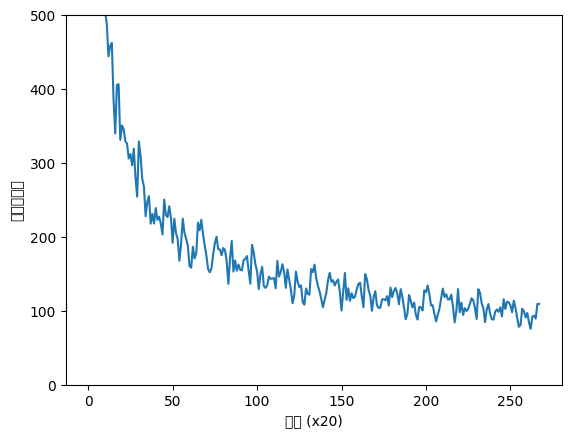

In [133]:
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad, eval_interval=20)
trainer.plot(ylim=(0, 500))

퍼블렉서티(후보지)가 줄어든 것을 확인할 수 있다.